In [1]:
from tensorflow.keras.applications import VGG19, DenseNet201
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout,Conv2D, BatchNormalization,Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
import cv2 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import mark_boundaries
import os
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pprint
from collections import deque
import copy
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
from sklearn.utils import shuffle

2025-12-17 13:32:16.739585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765978336.940733      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765978336.997169      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Project Setup and Data Loading

In [2]:
base_path = "/kaggle/input/chest-xray-covid19-pneumonia"
categories = ['NORMAL', 'COVID19', 'PNEUMONIA']
image_size = (224,224)

In [3]:
def load_images_from_folder(folder, label_name, images_list, labels_list):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            images_list.append(img)
            labels_list.append(label_name)

In [4]:
# Load training data
train_path = os.path.join(base_path, 'Data', 'train')
train_images, train_labels = [], []

for category in categories:
    category_path = os.path.join(train_path, category)
    print(f"Loading training data from {category_path}...")
    load_images_from_folder(category_path, category, train_images, train_labels)

Loading training data from /kaggle/input/chest-xray-covid19-pneumonia/Data/train/NORMAL...
Loading training data from /kaggle/input/chest-xray-covid19-pneumonia/Data/train/COVID19...
Loading training data from /kaggle/input/chest-xray-covid19-pneumonia/Data/train/PNEUMONIA...


In [5]:
# Load test data
test_path = os.path.join(base_path, 'Data', 'test')
test_images, test_labels = [], []

for category in categories:
    category_path = os.path.join(test_path, category)
    print(f"Loading test data from {category_path}...")
    load_images_from_folder(category_path, category, test_images, test_labels)

Loading test data from /kaggle/input/chest-xray-covid19-pneumonia/Data/test/NORMAL...
Loading test data from /kaggle/input/chest-xray-covid19-pneumonia/Data/test/COVID19...
Loading test data from /kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA...


In [6]:
img_shape = (224, 224, 3)
num_classes = 3

In [7]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [8]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)
test_images, test_labels = shuffle(test_images, test_labels, random_state=42)

In [9]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [10]:
label_mapping = {'COVID19': 0, 'PNEUMONIA': 1,'NORMAL': 2}

train_labels_int = np.array([label_mapping[label] for label in train_labels], dtype='int32')
test_labels_int = np.array([label_mapping[label] for label in test_labels], dtype='int32')

train_labels_one_hot = tf.keras.utils.to_categorical(train_labels_int, num_classes).astype('float32')
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels_int, num_classes).astype('float32')

In [11]:
train_images.shape

(5144, 224, 224, 3)

In [12]:
test_images.shape

(1288, 224, 224, 3)


# tabu search 

In [14]:
search_space = {
    'learning_rate': [1e-5, 1e-3, 1e-5],  # [min, max, step]
    'batch_size':    [8, 64, 8],
    'conv_filters':  [32, 128, 16],
    'n_conv_layers': [4, 10, 2],
    'dense_units_1': [64, 256, 64],
    'dense_units_2': [32, 128, 32],
    'dropout_rate':  [0.0, 0.7, 0.1] 
}



In [15]:
# Define the order of keys to map vector indices to dictionary keys reliably
PARAM_KEYS = list(search_space.keys())

def build_model(params):
    """Builds the Keras model from a param dictionary."""
    inputs = Input(shape=img_shape)

    # Convert params to int where necessary (WOA produces floats)
    filters = int(params['conv_filters'])
    layers = int(params['n_conv_layers'])
    dense1 = int(params['dense_units_1'])
    dense2 = int(params['dense_units_2'])
    drop_rate = float(params['dropout_rate'])

    x = Conv2D(filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    for i in range(layers):
        x = Conv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(dense1, activation='relu')(x)
    x = Dropout(drop_rate)(x)
    x = Dense(dense2, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x) 

    model = Model(inputs=inputs, outputs=outputs)
    return model



# tabu with whale

In [16]:
def evaluate_solution(solution_params, X_train, y_train, X_val, y_val, eval_epochs=5):
    print("\n--- Evaluating Solution ---")
    pprint.pprint(solution_params)
    
    tf.keras.backend.clear_session()

    try:
        batch_size = int(solution_params['batch_size'])
        learning_rate = float(solution_params['learning_rate'])

        model = build_model(solution_params)
        model.compile(optimizer=Adam(learning_rate=learning_rate), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=batch_size,
            epochs=eval_epochs,
            verbose=0  # Silent training to keep logs clean
        )

        best_val_acc = max(history.history['val_accuracy'])
        print(f"Result: Val Acc: {best_val_acc:.4f}")
        del model
        return best_val_acc

    except Exception as e:
        print(f"Error evaluating params: {e}")
        return 0.0

# --- 3. WHALE OPTIMIZATION ALGORITHM (WOA) HELPERS ---

def vector_to_params(vector):
    """
    Converts a continuous WOA vector back to the discrete parameter dictionary.
    """
    params = {}
    for i, key in enumerate(PARAM_KEYS):
        min_val, max_val, step = search_space[key]
        
        # Clip vector value to bounds
        val = max(min_val, min(vector[i], max_val))
        
        # Snap to nearest step
        if step is not None and step > 0:
            steps_count = round((val - min_val) / step)
            val = min_val + (steps_count * step)
        
        # Enforce Bounds one last time after stepping
        val = max(min_val, min(val, max_val))
        
        # Round integers
        if key in ['batch_size', 'conv_filters', 'n_conv_layers', 'dense_units_1', 'dense_units_2']:
            params[key] = int(round(val))
        else:
            params[key] = val
            
    return params

def init_whales(num_whales, dim):
    """Initialize whales within the specific bounds of the search space."""
    whales = np.zeros((num_whales, dim))
    for i, key in enumerate(PARAM_KEYS):
        min_val, max_val, _ = search_space[key]
        whales[:, i] = np.random.uniform(min_val, max_val, num_whales)
    return whales

def check_bounds(whale_pos):
    """Ensure whale stays within search space bounds."""
    new_pos = np.copy(whale_pos)
    for i, key in enumerate(PARAM_KEYS):
        min_val, max_val, _ = search_space[key]
        new_pos[i] = np.clip(new_pos[i], min_val, max_val)
    return new_pos

# --- 4. MAIN WOA OPTIMIZER FUNCTION ---

def whale_optimization_algorithm(X_train, y_train, X_val, y_val, 
                                 num_whales=5, max_iter=5, eval_epochs=3):
    
    dim = len(PARAM_KEYS)
    whales = init_whales(num_whales, dim)
    
    best_whale_pos = np.zeros(dim)
    best_whale_score = -float('inf') # We want to MAXIMIZE accuracy
    
    # 1. Evaluate Initial Population
    print(f"--- Initializing Population of {num_whales} Whales ---")
    current_scores = []
    
    for i in range(num_whales):
        print(f"Whale {i+1}:")
        params = vector_to_params(whales[i])
        score = evaluate_solution(params, X_train, y_train, X_val, y_val, eval_epochs)
        current_scores.append(score)
        
        if score > best_whale_score:
            best_whale_score = score
            best_whale_pos = whales[i].copy()
            
    print(f"Initial Best Score: {best_whale_score:.4f}")

    # 2. Main Loop
    for t in range(max_iter):
        print(f"\n===== WOA Iteration {t+1}/{max_iter} =====")
        
        a = 2 - t * (2 / max_iter) # a decreases linearly from 2 to 0
        
        for i in range(num_whales):
            r1 = np.random.random()
            r2 = np.random.random()
            
            A = 2 * a * r1 - a
            C = 2 * r2
            
            b = 1
            l = (np.random.random() * 2) - 1 # Random number in [-1, 1]
            p = np.random.random()
            
            new_pos = whales[i].copy()
            
            if p < 0.5:
                if abs(A) < 1:
                    # Encircling Prey (Update position towards best solution)
                    D = abs(C * best_whale_pos - whales[i])
                    new_pos = best_whale_pos - A * D
                else:
                    # Search for Prey (Select random whale)
                    rand_idx = np.random.randint(0, num_whales)
                    rand_whale = whales[rand_idx]
                    D = abs(C * rand_whale - whales[i])
                    new_pos = rand_whale - A * D
            else:
                # Bubble-net attacking (Spiral update)
                D_prime = abs(best_whale_pos - whales[i])
                new_pos = D_prime * np.exp(b * l) * np.cos(2 * np.pi * l) + best_whale_pos
            
            # Boundary Check and Update
            whales[i] = check_bounds(new_pos)
            
            # Evaluate New Position
            print(f"Whale {i+1} Move:")
            params = vector_to_params(whales[i])
            score = evaluate_solution(params, X_train, y_train, X_val, y_val, eval_epochs)
            
            if score > best_whale_score:
                best_whale_score = score
                best_whale_pos = whales[i].copy()
                print(f"*** NEW GLOBAL BEST FOUND: {best_whale_score:.4f} ***")

    best_params = vector_to_params(best_whale_pos)
    return best_params, best_whale_score



In [17]:
# --- 5. EXECUTION ---

# Parameters for the Whale Algorithm
WOA_AGENTS = 3       # Number of whales (Keep low for speed in this example)
WOA_ITERATIONS = 3   # Number of iterations
TRAIN_EPOCHS = 3     # Epochs per evaluation

print("Starting Whale Optimization Algorithm...")

best_hyperparams, best_score = whale_optimization_algorithm(
    train_images, train_labels_one_hot,
    test_images, test_labels_one_hot,
    num_whales=WOA_AGENTS,
    max_iter=WOA_ITERATIONS,
    eval_epochs=TRAIN_EPOCHS
)

print("\n\n=============================================")
print("OPTIMIZATION COMPLETE")
print(f"Best Accuracy Achieved: {best_score:.4f}")
print("Best Hyperparameters:")
pprint.pprint(best_hyperparams)
print("=============================================\n")



Starting Whale Optimization Algorithm...
--- Initializing Population of 3 Whales ---
Whale 1:

--- Evaluating Solution ---
{'batch_size': 24,
 'conv_filters': 80,
 'dense_units_1': 192,
 'dense_units_2': 64,
 'dropout_rate': 0.30000000000000004,
 'learning_rate': 0.0007000000000000001,
 'n_conv_layers': 10}
Result: Val Acc: 0.7182
Whale 2:

--- Evaluating Solution ---
{'batch_size': 64,
 'conv_filters': 64,
 'dense_units_1': 192,
 'dense_units_2': 96,
 'dropout_rate': 0.1,
 'learning_rate': 0.00023,
 'n_conv_layers': 8}
Result: Val Acc: 0.6638
Whale 3:

--- Evaluating Solution ---
{'batch_size': 48,
 'conv_filters': 96,
 'dense_units_1': 128,
 'dense_units_2': 64,
 'dropout_rate': 0.6000000000000001,
 'learning_rate': 0.00039000000000000005,
 'n_conv_layers': 8}
Result: Val Acc: 0.6739
Initial Best Score: 0.7182

===== WOA Iteration 1/3 =====
Whale 1 Move:

--- Evaluating Solution ---
{'batch_size': 24,
 'conv_filters': 80,
 'dense_units_1': 192,
 'dense_units_2': 64,
 'dropout_rate': 

In [18]:
# --- 6. TRAIN FINAL MODEL ---

print("Training final model with best hyperparameters...")

final_model = build_model(best_hyperparams)
final_model.compile(
    optimizer=Adam(learning_rate=best_hyperparams['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

history = final_model.fit(
    train_images, train_labels_one_hot,
    batch_size=int(best_hyperparams['batch_size']),
    epochs=10, # Longer training for final result
    validation_split=0.15,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)],
    verbose=1
)

print("\nFinal Model Summary:")
final_model.summary()

Training final model with best hyperparameters...
Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - accuracy: 0.7841 - loss: 0.5255 - precision: 0.8175 - recall: 0.7011 - val_accuracy: 0.7992 - val_loss: 0.6176 - val_precision: 0.8072 - val_recall: 0.7863 - learning_rate: 3.7000e-04
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9227 - loss: 0.2240 - precision: 0.9305 - recall: 0.9189 - val_accuracy: 0.9404 - val_loss: 0.1868 - val_precision: 0.9436 - val_recall: 0.9326 - learning_rate: 3.7000e-04
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9295 - loss: 0.2014 - precision: 0.9315 - recall: 0.9264 - val_accuracy: 0.9456 - val_loss: 0.1796 - val_precision: 0.9455 - val_recall: 0.9443 - learning_rate: 3.7000e-04
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9477 - loss: 0.1665 - precision: 0.9497 - recall: 0.9452 - val_accuracy: 0.9210 - val_loss: 0.2001 - val_precision: 0.9230 - val_recall: 0.9158 - learning_rate: 3

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 933,899 (3.56 MB)

 Trainable params: 310,915 (1.19 MB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 621,832 (2.37 MB)

# test 

In [19]:
# Evaluate the model on the test set
test_loss, test_acc, test_precision, test_recall = final_model.evaluate(
    test_images, 
    test_labels_one_hot, 
    verbose=0
)

print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 86.65%


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step


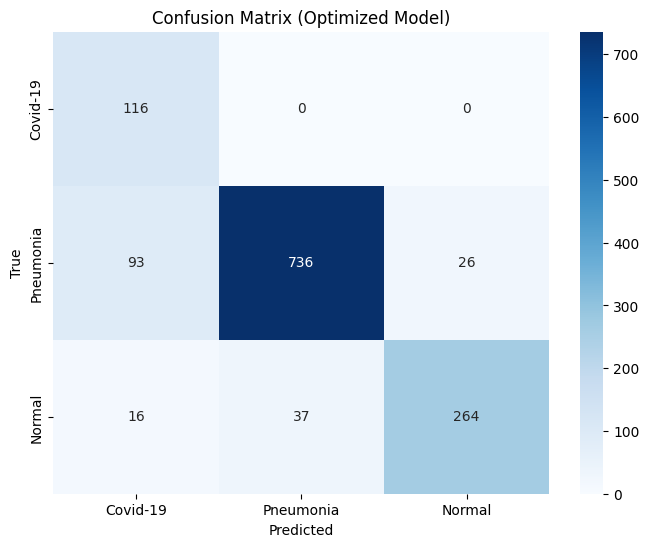

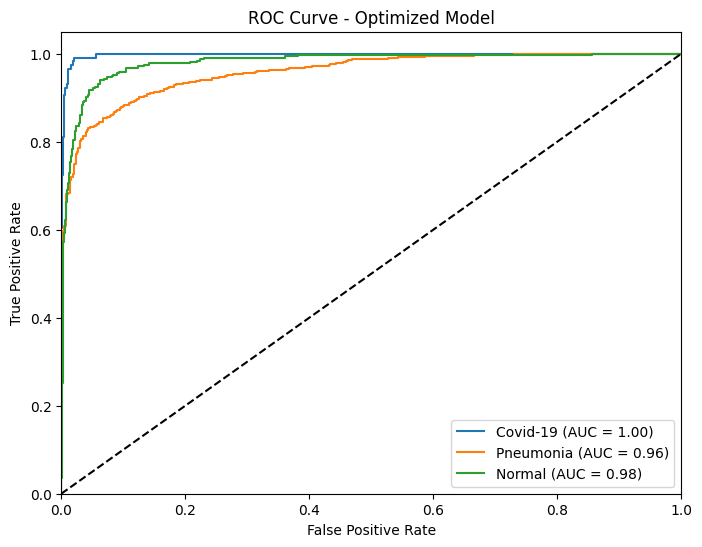

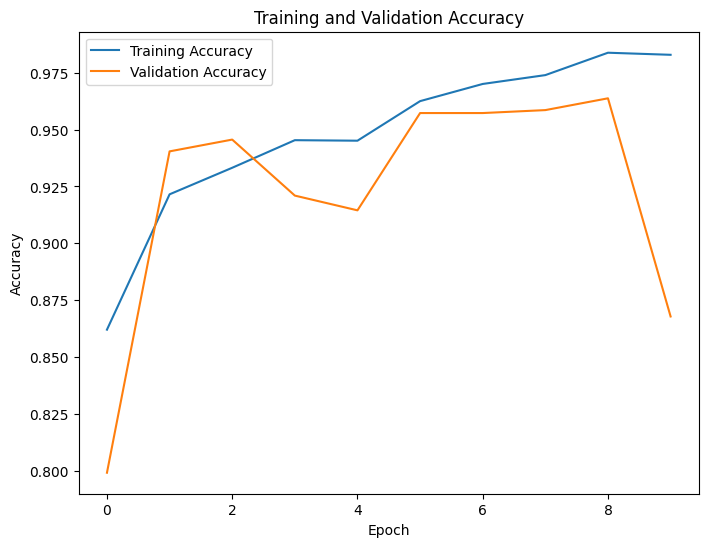

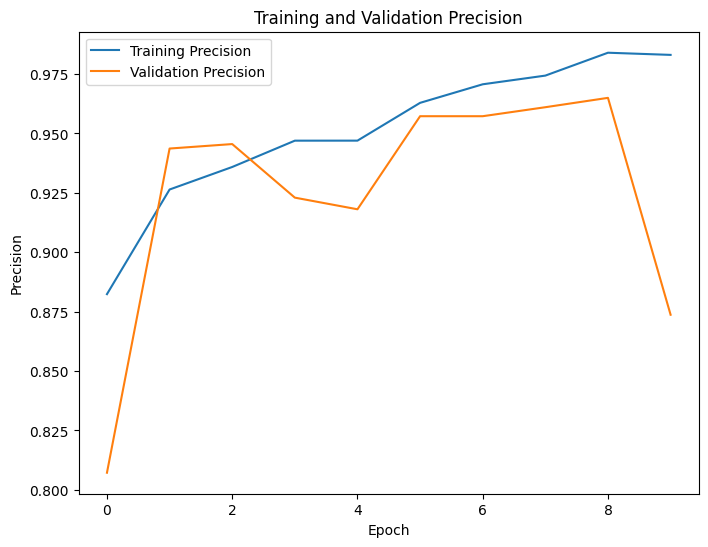

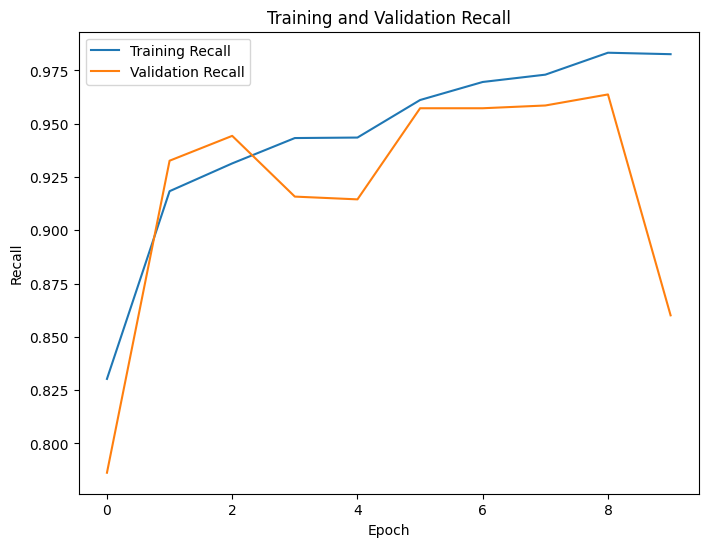

In [21]:
y_pred_probs = final_model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_labels_one_hot, axis=1)

# Ensure 'final_history' matches the variable name from model.fit()
final_history = history 

# ==========================================
# STEP 3: CONFUSION MATRIX
# ==========================================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Covid-19', 'Pneumonia', 'Normal'], 
            yticklabels=['Covid-19', 'Pneumonia', 'Normal'])
plt.title('Confusion Matrix (Optimized Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ==========================================
# STEP 4: PLOT ROC CURVES
# ==========================================
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(8, 6))

for i in range(num_classes):
    # Calculate ROC for each class
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot
    # Ensure class names match your specific data order. Adjust if necessary.
    class_names = ['Covid-19', 'Pneumonia', 'Normal']
    if i < len(class_names):
        label_name = f'{class_names[i]} (AUC = {roc_auc[i]:.2f})'
    else:
        label_name = f'Class {i} (AUC = {roc_auc[i]:.2f})'
        
    plt.plot(fpr[i], tpr[i], label=label_name)

plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Optimized Model')
plt.legend(loc="lower right")
plt.show()

# ==========================================
# STEP 5: PLOT TRAINING HISTORY
# ==========================================
history_keys = final_history.history.keys()

# 1. Accuracy Plot
plt.figure(figsize=(8, 6))
plt.plot(final_history.history['accuracy'], label='Training Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 2. Precision Plot (Only if available)
if 'precision' in history_keys:
    plt.figure(figsize=(8, 6))
    plt.plot(final_history.history['precision'], label='Training Precision')
    plt.plot(final_history.history['val_precision'], label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

# 3. Recall Plot (Only if available)
if 'recall' in history_keys:
    plt.figure(figsize=(8, 6))
    plt.plot(final_history.history['recall'], label='Training Recall')
    plt.plot(final_history.history['val_recall'], label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()